## Iinit setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#export
import gzip
from pathlib import Path
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F

### Get data

In [ ]:
def get_mnist():
    data_file = Path('/home/magda/datasets/mnist')/'mnist.pkl.gz'
    with gzip.open(data_file, 'rb') as f:
        (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = pickle.load(f, encoding='latin1')
    train_x, valid_x, test_x, = [
        torch.tensor(x, dtype=torch.float) for x in (train_x, valid_x, test_x)]
    train_y, valid_y, test_y = [torch.tensor(x, dtype=torch.long).unsqueeze(-1) for x in (train_y, valid_y, test_y)]
#     train_x, train_y, valid_x, valid_y, test_x, test_y = [
#         torch.tensor(x, dtype=torch.float) for x in (train_x, train_y, valid_x, valid_y, test_x, test_y)]
#     train_y, valid_y, test_y = [torch.unsqueeze(x, -1) for x in (train_y, valid_y, test_y)]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

In [ ]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_mnist()
train_x.shape

In [ ]:
def normalize(x, center, scale):
    return (x - center) / scale

In [ ]:
center_x = train_x.mean()
scale_x = train_x.std()
train_x, valid_x, test_x = [normalize(x, center_x, scale_x) for x in (train_x, valid_x, test_x)]
valid_x.mean(), valid_x.std()

### Define basic model (torch.nn)

In [ ]:
num_in, dim_in = train_x.shape
dim_hidden = 50
dim_out = torch.unique(train_y).numel()
dim_out

In [ ]:
class MyNet(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(MyNet, self).__init__()
        self.layers = [nn.Linear(d_in, d_hidden), nn.ReLU(), nn.Linear(d_hidden, d_out)]
        for l, layer in enumerate(self.layers):
            self.add_module(f'layer_{l}', layer)
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
mynet = MyNet(dim_in, dim_hidden, dim_out)

In [ ]:
mynet

In [ ]:
for param in mynet.named_parameters():
    print(param)

In [ ]:
outs = mynet(train_x)
outs

### cross entropy loss

$$\frac{\exp(x_i)}{\sum_i \exp(x_i)}$$

In [ ]:
def softmax(logits):
    exps = logits.exp()
    return exps / exps.sum(1, keepdims=True)

In [ ]:
softmax(outs).sum(1)

### log-softmax

In [ ]:
def log_softmax(logits):
    return softmax(logits).log()

In [ ]:
log_softmax(outs)[[0, 1, 2], train_y[:3].squeeze(-1)]

### nll

In [ ]:
def nll(logits, targets):
    return -log_softmax(logits)[[range(num_in)], targets.squeeze(-1)].mean()

In [ ]:
nll(outs, train_y)

### log-softmax directly + nll

In [ ]:
def log_softmax2(logits):
    return logits - logits.exp().sum(1, keepdims=True).log()

In [ ]:
def nll2(logits, targets):
    return -log_softmax2(logits)[[range(num_in)], targets.squeeze(-1)].mean()

In [ ]:
from exp.nb_01Magda import *
test_near(nll(outs, train_y), nll2(outs, train_y))

### logsumexp + log-softmax + nll

$$\log \sum_i \exp(x_i) = \log \sum_i [\exp(x_i) \frac{\exp(max_x)}{\exp(max_x)}] = \log [\exp(max_x) \sum_i \exp(x_i - max_x)] = max_x + \log \sum_i \exp(x_i - max_x)$$

In [ ]:
def logsumexp(x):
    max_x, _ = x.max(1, keepdim=True)
    return (max_x + (x-max_x).exp().sum(1, keepdim=True).log())

In [ ]:
def nll3(logits, targets):
    return -(logits - logsumexp(logits))[[range(num_in)], targets.squeeze(-1)].mean()

In [ ]:
test_near(nll(outs, train_y), nll3(outs, train_y))

### F.nll and F.cross-entropy

In [ ]:
nll_torch = F.nll_loss(log_softmax(outs).squeeze(-1), train_y.squeeze(-1))
nll_torch

In [ ]:
nll_my = nll3(outs, train_y)
nll_my

In [ ]:
test_near(nll_torch, nll_my)

In [ ]:
cross_entropy = F.cross_entropy(outs.squeeze(-1), train_y.squeeze(-1))
cross_entropy

In [ ]:
test_near(logsumexp(outs), outs.logsumexp(1, keepdim=True))

In [ ]:
test_near(softmax(outs), outs.softmax(1))

## basic training loop

* get output over batch
* compute loss
* get gradients
* update parameters

`get_mnist` once again with targets rank 1 vectors long integers

In [3]:
#export
def get_mnist():
    data_file = Path('/home/magda/datasets/mnist')/'mnist.pkl.gz'
    with gzip.open(data_file, 'rb') as f:
        (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = pickle.load(f, encoding='latin1')
    train_x, valid_x, test_x, = [
        torch.tensor(x, dtype=torch.float) for x in (train_x, valid_x, test_x)]
    train_y, valid_y, test_y = [torch.tensor(x, dtype=torch.long) for x in (train_y, valid_y, test_y)]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

In [4]:
#export
def normalize(data_for_stats, data_to_norm=None):
    if data_to_norm is None:
        data_to_norm = data_for_stats
    center = data_for_stats.mean()
    scale = data_for_stats.std()
    return (data_to_norm - center) / scale

In [ ]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_mnist()

In [ ]:
from functools import partial
norm_by_train = partial(normalize, data_to_norm = train_x)

In [ ]:
train_x, valid_x, test_x = [norm_by_train(x) for x in (train_x, valid_x, test_x)]

In [ ]:
test_x.mean(), test_x.std()

In [ ]:
num_in, dim_in = train_x.shape
dim_hidden = 50
dim_out = torch.unique(train_y).numel()
dim_out

### manual batch loading + manual SGD (torch.nn.functional mse loss)

In [ ]:
class MyNet(nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(MyNet, self).__init__()
        self.lin1 = nn.Linear(d_in, d_hidden)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(d_hidden, d_out)
        
    def __call__(self,x):
        x = self.lin1(x)
        x = self.relu(x)
        return self.lin2(x)    

In [ ]:
mynet = MyNet(dim_in, dim_hidden, dim_out)

In [ ]:
loss_func = F.cross_entropy
loss_func

In [ ]:
batch_size = 5000
num_epochs = 10
learn_rate = 0.01

In [ ]:
losses = []
for epoch in range(num_epochs):
    print('Epoch: ', epoch)
    loss_epoch = 0
    for bidx, bstart in enumerate(range(0, num_in, batch_size)):
        batch_x = train_x[bstart:bstart+batch_size]
        batch_y = train_y[bstart:bstart+batch_size]
        outs = mynet(batch_x)
        loss = loss_func(outs, batch_y)
        loss.backward()
        with torch.no_grad():
            for param in mynet.parameters():
                param -= learn_rate * param.grad
            mynet.zero_grad()
        loss_epoch += loss
    print('loss', loss_epoch / (bidx+1))
    losses.append(loss_epoch / (bidx+1))

### parameters

* use `nn.Module.__setattr__`

### registering modules

#### nn.ModuleList

In [ ]:
layers = [nn.Linear(dim_in, dim_hidden), nn.ReLU(), nn.Linear(dim_hidden, dim_out)]
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
model = MyModel()
model

#### nn.Sequential

In [ ]:
model_seq  = nn.Sequential(
    nn.Linear(dim_in, dim_hidden),
    nn.ReLU(),
    nn.Linear(dim_hidden, dim_out)
)

In [ ]:
model_seq

In [ ]:
model_seq.parameters()

In [ ]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
    ('lin1', nn.Linear(dim_in, dim_hidden)),
    ('relu', nn.ReLU()),
    ('lin2', nn.Linear(dim_hidden, dim_out))
]))

In [ ]:
model

### optim

* replace the manual optimizer with coded one so to use
    `opt.step()`
    `opt.zero_grad()`

In [ ]:
loss_func = F.cross_entropy

batch_size = 5000
num_epochs = 30
learn_rate = 0.01

In [ ]:
class Optimizer():
    def __init__(self, model, lr):
        self.parameters = model.parameters
        self.lr = lr
    
    def step(self):
        for param in self.parameters():
            param -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.parameters():
            param.grad.zero_()

In [ ]:
optimizer = Optimizer(model_seq, learn_rate)
optimizer

In [ ]:
def fit(model):
    losses = []
    for epoch in range(num_epochs):
        loss_epoch = 0
        for bidx, bstart in enumerate(range(0, num_in, batch_size)):
            batch_x = train_x[bstart:bstart+batch_size]
            batch_y = train_y[bstart:bstart+batch_size]
            outs = model(batch_x)
            loss = loss_func(outs, batch_y)
            loss.backward()
            with torch.no_grad():
                optimizer.step()
                optimizer.zero_grad()
            loss_epoch += loss
        losses.append(loss_epoch/bidx)
    return losses

In [ ]:
losses = fit(model_seq)

In [ ]:
plt.plot(range(num_epochs), losses)

In [ ]:
from torch import optim
optimizer = optim.SGD(model_seq.parameters(), learn_rate)
losses = fit(model_seq)
plt.plot(range(num_epochs), losses)

## Data set and dataLoader

In [5]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_mnist()

In [6]:
from functools import partial
norm_by_train = partial(normalize, data_for_stats = train_x)
train_x, valid_x, test_x = [norm_by_train(data_to_norm=x) for x in (train_x, valid_x, test_x)]

In [7]:
num_in, dim_in = train_x.shape
dim_hidden = 50
dim_out = torch.unique(train_y).numel()
dim_out

10

In [8]:
batch_size = 5000
num_epochs = 10
learn_rate = 0.01

In [9]:
loss_func = F.cross_entropy

In [10]:
from torch import optim
def get_model():
    model = nn.Sequential(
        nn.Linear(dim_in, dim_hidden),
        nn.ReLU(),
        nn.Linear(dim_hidden, dim_out)
    )
    optimizer = optim.SGD(model.parameters(), lr=learn_rate)
    return model, optimizer

In [11]:
model, optimizer = get_model()

In [ ]:
optimizer

In [ ]:
get_model.__name__

### Data set

In [ ]:
class DataSet():
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, key):
        return self.x[key], self.y[key]

In [ ]:
train_data = DataSet(train_x, train_y)

In [ ]:
len(train_data)

In [ ]:
train_data[:5]

In [ ]:
train_x[:5] - train_data[:5][0]

In [ ]:
train_y[:5] - train_data[:5][1]

### DataLoader

In [ ]:
class DataLoader():
    def __init__(self, dataset, batchsize):
        self.dataset = dataset
        self.batchsize = batchsize
        self.size = len(dataset)
    
    def __iter__(self):
        for bstart in range(0, self.size, self.batchsize):
            yield self.dataset[bstart:bstart+self.batchsize]

In [ ]:
dataloader = DataLoader(train_data, 5000)

In [ ]:
def get_model():
    model = nn.Sequential(
        nn.Linear(dim_in, dim_hidden),
        nn.ReLU(),
        nn.Linear(dim_hidden, dim_out)
    )
    optimizer = optim.SGD(model.parameters(), lr=learn_rate)
    return model, optimizer

model, optimizer=get_model()

In [ ]:
def fit():
    losses = []
    for epoch in range(num_epochs):
        loss_epoch = torch.zeros((1))
        for bidx, (batch_x, batch_y) in enumerate(dataloader):
            outs = model(batch_x)
            loss = loss_func(outs, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_epoch += loss
        losses.append(loss_epoch / bidx)
    return losses

In [ ]:
import matplotlib.pyplot as plt
losses = fit()
plt.plot(losses)

### Random sampling

In [ ]:
class Shuffler():
    def __init__(self, ds, bs, shuffle=True):
        self.ds_len = len(ds)
        self.bs = bs
        self.idx = torch.randperm(self.ds_len) if shuffle else torch.arange(self.ds_len)
    
    def __iter__(self):
        for i in range(0, self.ds_len, self.bs):
            yield self.idx[i:i+self.bs]

In [ ]:
class DataLoader():
    def __init__(self, ds, bs, shuffle=True):
        self.ds = ds
        self.shuffler = iter(Shuffler(ds, bs, shuffle))
        
    def __next__(self):
        idx = next(self.shuffler)
        return self.ds[idx]

In [ ]:
data_loader = DataLoader(train_data, 9)

In [ ]:
batch = next(data_loader)
imgs_tmp = batch[0].view(3, 3, 28, -1).permute(0,2,1,3)
plt.imshow(imgs_tmp.reshape(3*28, 3*28), cmap='gray')
plt.axis('off');

### Pytorch DataLoader

In [12]:
from torch.utils.data import TensorDataset, DataLoader, Sampler

In [13]:
train_data = TensorDataset(train_x, train_y)

In [29]:
train_loader = DataLoader(train_data, batch_size = 5000, shuffle=True)

In [ ]:
for i, batch in enumerate(train_loader):
    imgs_tmp = batch[0].view(3, 3, 28, -1).permute(0,2,1,3)
    plt.imshow(imgs_tmp.reshape(3*28, 3*28), cmap='gray')
    plt.axis('off');
    if i==1:
        break

In [ ]:
train_iter = iter(train_loader)

In [ ]:
batch = next(train_iter)
imgs_tmp = batch[0].view(3, 3, 28, -1).permute(0,2,1,3)
plt.imshow(imgs_tmp.reshape(3*28, 3*28), cmap='gray')
plt.axis('off');

### Validation

In [15]:
valid_data = TensorDataset(valid_x, valid_y)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)

In [49]:
#export
def get_accuracy(logits, targets):
    preds = logits.argmax(1)
    return (preds==targets).float().mean()

In [35]:
def fit():
    train_losses = []
    valid_losses = []
    valid_accuracy = []
    for epoch in range(num_epochs):
        model.train()
        losses = 0.
        for bidx, (batch_x, batch_y) in enumerate(train_loader):
            logits = model(batch_x)
            loss = loss_func(logits, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses += loss.item()
        train_losses.append(losses/ (bidx+1.))
        print(epoch, train_losses)
        model.eval()
        with torch.no_grad():
            losses = 0.
            accuracies = 0.
            for bidx, (batch_x, batch_y) in enumerate(valid_loader):
                logits = model(batch_x)
                loss = loss_func(logits, batch_y)
                accuracy = get_accuracy(logits, batch_y)
                losses += loss.item()
                accuracies += accuracy.item()
            valid_losses.append(losses/(bidx+1.))
            valid_accuracy.append(accuracies/(bidx+1.))
    return train_losses, valid_losses, valid_accuracy

In [36]:
train_losses, valid_losses, valid_accuracy = fit()

0 [0.09519079998135567]
1 [0.09519079998135567, 0.09422180503606796]
2 [0.09519079998135567, 0.09422180503606796, 0.09350590482354164]
3 [0.09519079998135567, 0.09422180503606796, 0.09350590482354164, 0.09294303432106972]
4 [0.09519079998135567, 0.09422180503606796, 0.09350590482354164, 0.09294303432106972, 0.0924816906452179]
5 [0.09519079998135567, 0.09422180503606796, 0.09350590482354164, 0.09294303432106972, 0.0924816906452179, 0.0920834295451641]
6 [0.09519079998135567, 0.09422180503606796, 0.09350590482354164, 0.09294303432106972, 0.0924816906452179, 0.0920834295451641, 0.09174149855971336]
7 [0.09519079998135567, 0.09422180503606796, 0.09350590482354164, 0.09294303432106972, 0.0924816906452179, 0.0920834295451641, 0.09174149855971336, 0.09142805188894272]
8 [0.09519079998135567, 0.09422180503606796, 0.09350590482354164, 0.09294303432106972, 0.0924816906452179, 0.0920834295451641, 0.09174149855971336, 0.09142805188894272, 0.09114948958158493]
9 [0.09519079998135567, 0.09422180503

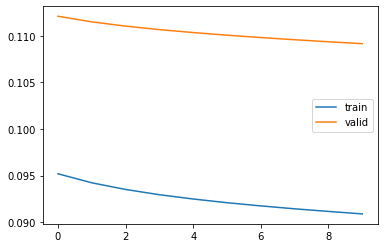

In [43]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend();

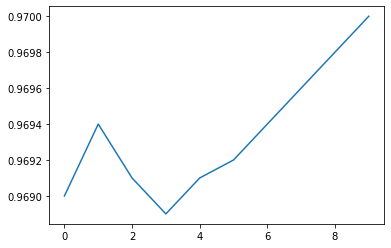

In [46]:
plt.plot(valid_accuracy)

In [50]:
!python notebook2script.py 03Magda_minibatch.ipynb

Converted 03Magda_minibatch.ipynb to exp/nb_03Magda.py
